In [54]:
import json
import os
import math
import tqdm

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "games", "classic")

for file in os.listdir(game_path):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in games:
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")



Loaded 10647 games.
Unique players: 84699


In [ ]:
def plot_level_distribution(games: list):
    import matplotlib.pyplot as plt

    # Levels einsammeln
    levels = []
    for game in games:
        for participant in game.get("info", {}).get("participants", []):
            levels.append(participant.get("summonerLevel", 0))

    # Figur
    plt.figure(figsize=(16, 10))

    # Histogramm mit schöneren Styles
    plt.hist(
        levels,
        bins=range(1, max(levels) + 2),
        edgecolor="green",        # dünne Linien für klarere Balken
        alpha=0.75,               # etwas Transparenz
        linewidth=1.0
    )
    plt.locator_params(axis="x", nbins=40)
    # Titel und Achsen
    plt.title("Distribution of Account Levels", fontsize=20, pad=15)
    plt.xlabel("Level", fontsize=16)
    plt.ylabel("Number of Accounts", fontsize=16)

    # Schönes Grid
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ticks lesbarer machen
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Layout optimieren
    plt.tight_layout()

    plt.show()

        

def get_team_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("summonerLevel", 0))
        else:
            team2_levels.append(participant.get("summonerLevel", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_percentage_of_surrendered_games(games: dict) -> float:
    surrendered_games = 0
    for game in games:
        s = game.get("info").get("participants", [])[0]["gameEndedInSurrender"]
        es = game.get("info").get("participants", [])[0]["gameEndedInEarlySurrender"]
        if s == True or es == True:
            surrendered_games += 1
    return surrendered_games/len(games)

def get_team_champion_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("champExperience", 0))
        else:
            team2_levels.append(participant.get("champExperience", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_team_min_max_level(game: dict) -> tuple:
    team1_max_level = 0
    team1_min_level = math.inf
    team2_max_level = 0
    team2_min_level = math.inf

    for p in game.get("info").get("participants", []):
        if p.get("teamId") == 100:
            if p.get("summonerLevel", 0) > team1_max_level:
                team1_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team1_min_level:
                team1_min_level = p.get("summonerLevel", 0)
        if p.get("teamId") == 200:
            if p.get("summonerLevel", 0) > team2_max_level:
                team2_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team2_min_level:
                team2_min_level = p.get("summonerLevel", 0)
    return ((team1_min_level, team1_max_level), (team2_min_level, team2_max_level))

def higher_absolute_level_winrate(games:list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_max_level = 0
    won_with_lower_max_level = 0

    for game in games:
        l = get_team_min_max_level(game)
        team1_min_level, team1_max_level = l[0]
        team2_min_level, team2_max_level = l[1]
        team1_win = False
        team2_win = False

        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True

        if team1_max_level > team2_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_higher_max_level += 1
            if team2_win:
                won_with_lower_max_level += 1

        if team2_max_level > team1_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_lower_max_level += 1
            if team2_win:
                won_with_higher_max_level += 1
    return won_with_higher_max_level/all_games

def higher_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def higher_champion_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_champion_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    print(f"{won_with_higher_level} Wins with higher champion level and {won_with_lower_level} Wins with lower champion level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def lower_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_lower_level/all_games
    else:
        return 0

def get_highest_level_player(games: list) -> tuple:
    highest_level = -1
    player_name = ""
    for game in games:
        for participant in game.get("info").get("participants", []):
            level = participant.get("summonerLevel", 0)
            if level > highest_level:
                highest_level = level
                player_name = participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")
    return player_name, highest_level



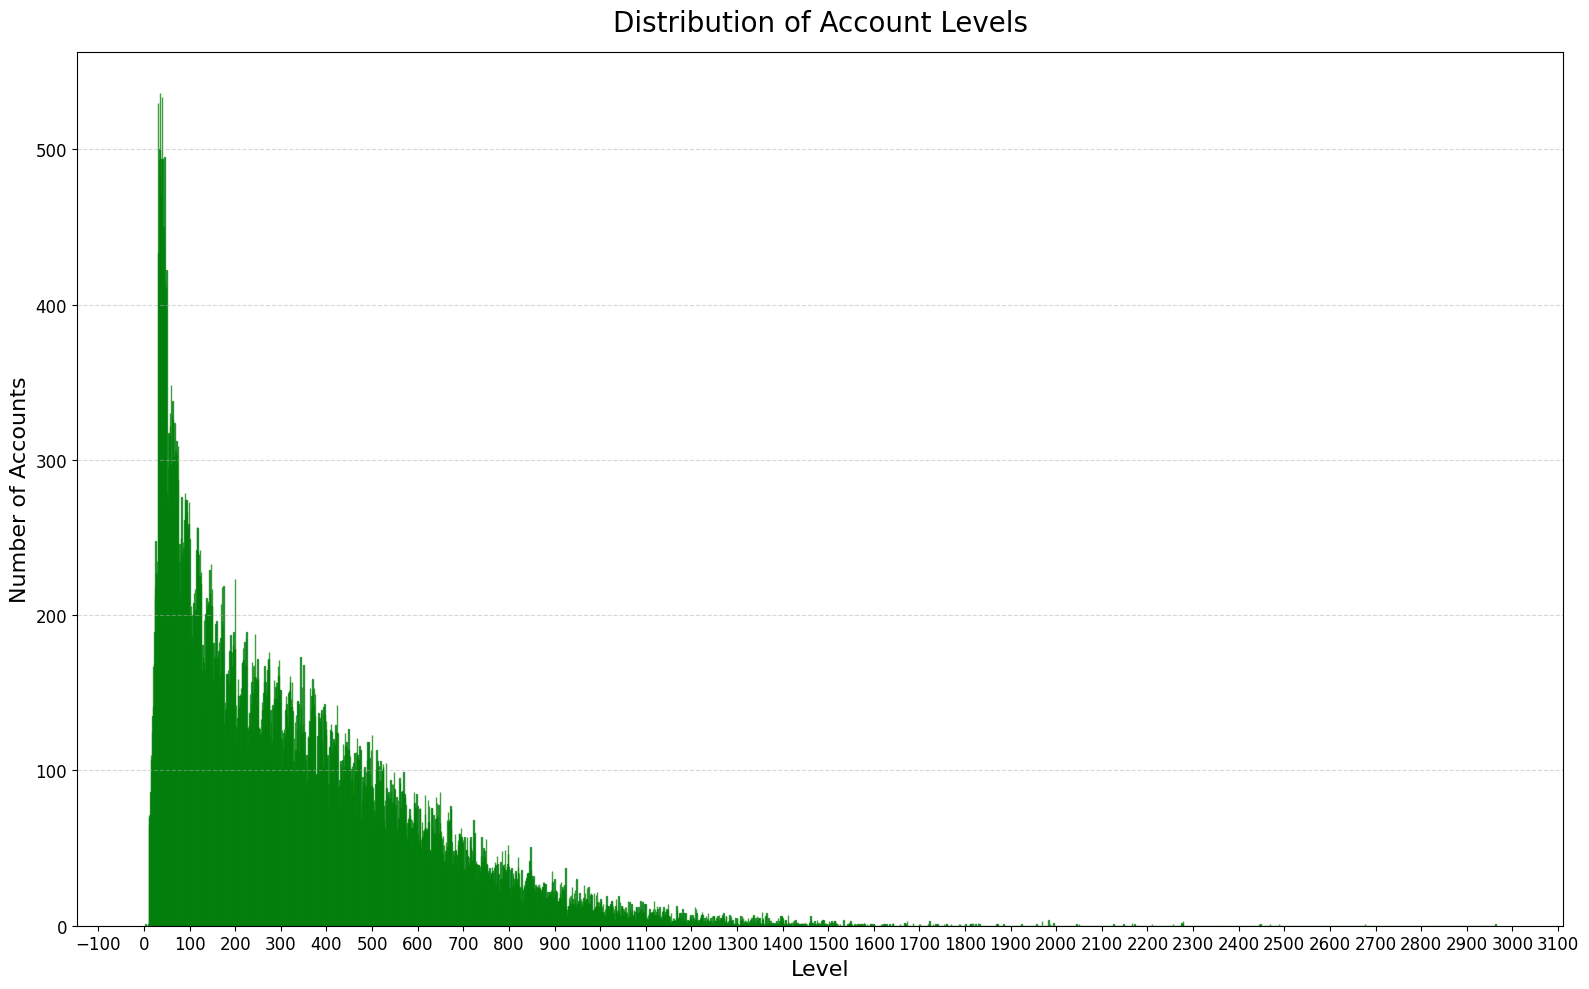

"Qnoxs #17165" Level: 2963


In [56]:
plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]
[0.3673469387755102, 0.56, 0.5396825396825397, 0.6140350877192983, 0.6578947368421053, 0.5, 0.5272727272727272, 0.4, 0.5333333333333333, 0.5106382978723404, 0.4358974358974359, 0.6551724137931034, 0.5813953488372093, 0.4146341463414634, 0.5294117647058824, 0.4, 0.3181818181818182, 0.391304347826087, 0.5833333333333334, 0.36363636363636365, 0.5882352941176471, 0.47058823529411764, 0.47058823529411764, 0.4666666666666667, 0.8333333333333334, 0.5, 0.8, 0.4117647058823529, 0.42105263157894735, 0.3333333333333333, 0.6666666666666666, 0.5714285714285714, 0.5, 0.6666666666666666, 0.7142857142857143, 0.5, 0.2857142857142857, 0.7142857142857143, 0.5, 0.5, 0.0, 0.5, 1.0, 0.6666666666666666, 0.4, 0.33333333

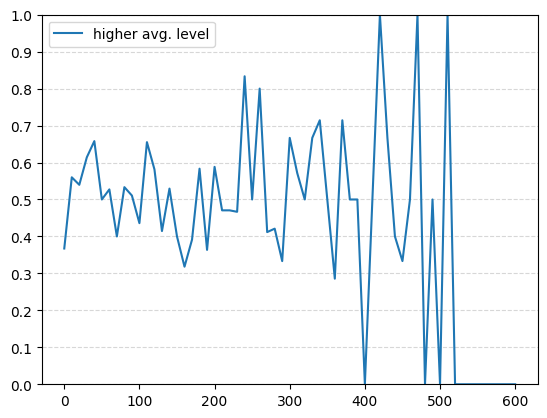

In [65]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_level_winrate(games, d)
    winrates_higher.append(wr)
    winrates_lower.append(lower_level_winrate(games, d))
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher avg. level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]
[0.5092122579432224, 0.5097110831964441, 0.5112169942426047, 0.5116302795347888, 0.5124027748581038, 0.5134170093053452, 0.5149420160570919, 0.515639374425023, 0.5151443164271291, 0.5152147239263803, 0.5149670218163369, 0.5164245517602408, 0.5148930408881668, 0.5146420064452851, 0.5162087512719872, 0.5167744847299534, 0.5164612264003745, 0.5185065459835139, 0.519591426657736, 0.5195908460471568, 0.5198991536106609, 0.52088772845953, 0.5219341002144667, 0.5227734851565677, 0.5197299008229584, 0.51945

ValueError: `bins` must increase monotonically, when an array

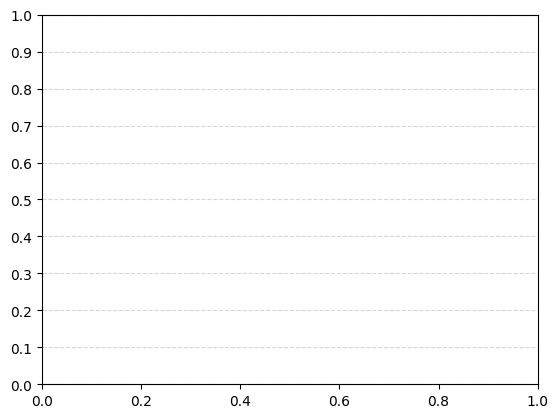

In [ ]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_absolute_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher absolute level")
plt.legend()
plt.show()

(21828.2, 18631.0)
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000]
10215 Wins with higher champion level and 418 Wins with lower champion level of 10633 games
10004 Wins with higher champion level and 340 Wins with lower champion level of 10344 games
9895 Wins with higher champion level and 307 Wins with lower champion level of 10202 games
9819 Wins with higher champion level and 283 Wins with lower champion level of 10102 games
9737 Wins with higher champion level and 259 Wins with lower champion level of 9996 games
9649 Wins with higher champion level and 231 Wins with lower champion level of 9880 games
9547 Wins with higher champion level and 207 Wins with lower champion level of 9

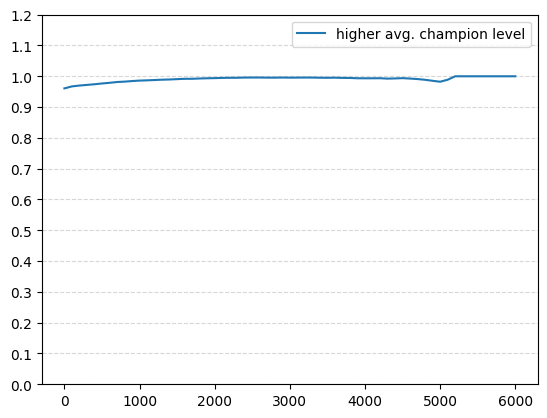

In [59]:
import matplotlib.pyplot as plt
print(get_team_champion_levels(games[1]))
diffs = [i * 100 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_champion_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 13)])
plt.plot(diffs, winrates_higher, label="higher avg. champion level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

In [60]:
print(get_percentage_of_surrendered_games(games))

0.30130553207476285
